In [51]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib.dates as mdates

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
#from keras.callbacks import EarlyStopping
from keras.layers import ConvLSTM2D
from keras.layers import Dense, Activation, Dense, Dropout
from past.builtins import xrange



In [52]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
data_all = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Currency Exchange Rate Prediction/assets/data_JPY.csv', index_col = 'Date')
#data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Currency Exchange Rate Prediction/assets/data_stock_20.csv', index_col = 'Date')

data_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2583 entries, 30-01-2014 to 29-12-2023
Data columns (total 45 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bull_bear         2583 non-null   int64  
 1   Open              2583 non-null   float64
 2   High              2583 non-null   float64
 3   Low               2583 non-null   float64
 4   Close             2583 non-null   float64
 5   Adj Close         2583 non-null   float64
 6   Volume            2583 non-null   int64  
 7   EURUSD            2583 non-null   float64
 8   GBPUSD            2583 non-null   float64
 9   AUDUSD            2583 non-null   float64
 10  NZDUSD            2583 non-null   float64
 11  EURJPY            2583 non-null   float64
 12  GBPJPY            2583 non-null   float64
 13  CNY               2583 non-null   float64
 14  HKD               2583 non-null   float64
 15  SGD               2583 non-null   float64
 16  INR               2583 non-null 

In [54]:
data = data_all.iloc[:2583 , :]

data = data.replace([np.inf, -np.inf], np.nan)
data = data.dropna()
#data = data.reset_index()
data.info()
data.head()


<class 'pandas.core.frame.DataFrame'>
Index: 2580 entries, 30-01-2014 to 29-12-2023
Data columns (total 45 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bull_bear         2580 non-null   int64  
 1   Open              2580 non-null   float64
 2   High              2580 non-null   float64
 3   Low               2580 non-null   float64
 4   Close             2580 non-null   float64
 5   Adj Close         2580 non-null   float64
 6   Volume            2580 non-null   int64  
 7   EURUSD            2580 non-null   float64
 8   GBPUSD            2580 non-null   float64
 9   AUDUSD            2580 non-null   float64
 10  NZDUSD            2580 non-null   float64
 11  EURJPY            2580 non-null   float64
 12  GBPJPY            2580 non-null   float64
 13  CNY               2580 non-null   float64
 14  HKD               2580 non-null   float64
 15  SGD               2580 non-null   float64
 16  INR               2580 non-null 

,bull_bear,Open,High,Low,Close,Adj Close,Volume,EURUSD,GBPUSD,AUDUSD,...,21lower,7rsv,14rsv,21rsv,FT_3components,FT_6components,FT_9components,FT_27components,FT_81components,FT_100components
Date,,,,,,,,,,,,,,,,,,,,,
30-01-2014,1,102.239998,102.779999,102.087997,102.300003,102.300003,0,1.365859,1.655903,0.874891,...,102.218774,9.671183,9.671183,7.635932,126.902733,121.992540,125.498734,123.406673,120.710219,120.360684
31-01-2014,1,102.727997,102.907997,102.014999,102.758003,102.758003,0,1.355877,1.649838,0.879585,...,102.116023,27.388798,27.388798,24.737956,126.847964,121.816287,125.178584,122.421427,118.222690,117.310228
03-02-2014,0,102.237999,102.393997,101.255997,102.192001,102.192001,0,1.348818,1.643791,0.875657,...,101.893958,10.757449,5.493166,4.961506,126.793148,121.640318,124.857734,121.440968,115.795829,114.363732
04-02-2014,0,101.156998,101.567001,100.783997,101.141998,101.141998,0,1.352503,1.630896,0.875044,...,101.464328,0.000000,0.000000,0.000000,126.738286,121.464649,124.536254,120.466733,113.457262,111.573478
05-02-2014,1,101.669998,101.671997,100.820999,101.689003,101.689003,0,1.351589,1.633053,0.891425,...,101.208143,26.184946,15.660009,14.775910,126.683379,121.289298,124.214216,119.500138,111.232925,108.986805


In [55]:
data = data_all[['bull_bear','Open','High','Low','Close','Adj Close','EURJPY','GBPJPY']]
col=data.shape[1]

In [56]:
data['y'] = data['Close']

x = data.iloc[:, :col].values
y = data.iloc[:, col].values
'''
x = data.iloc[:, :44].values
y = data.iloc[:, 44].values
'''
print(x)

[[  1.        102.2399979 102.7799988 ... 102.3000031 139.7129974
  169.3690033]
 [  1.        102.7279968 102.9079971 ... 102.7580032 139.3159943
  169.5      ]
 [  0.        102.237999  102.3939972 ... 102.1920013 137.8280029
  167.9499969]
 ...
 [  0.        142.4609985 142.8320007 ... 142.4609985 157.2949982
  181.2630005]
 [  0.        141.3990021 141.6519928 ... 141.3990021 157.0630035
  180.9499969]
 [  0.        141.4299927 141.8990021 ... 141.4299927 156.5269928
  180.0410004]]


<ipython-input-56-ccd1d8ae9001>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['y'] = data['Close']


In [236]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
#https://gist.github.com/lukovkin/1aefa4509e066690b892

#scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer
#data_trans= scaler.fit_transform(data)

data_trans= data
split = int(data_trans.shape[0]* 0.7)


seq_size = col  # Number of time steps to look back



trainX, trainY = x[: split, :], y[: split, ]
testX, testY = x[split:, :], y[split: , ]


print("Shape of training set: {}".format(trainX.shape))
print("Shape of test set: {}".format(testX.shape))


#trainX = trainX.reshape((trainX.shape[0], 1, 1, 1, seq_size))
#testX = testX.reshape((testX.shape[0], 1, 1, 1, seq_size))

print(trainX.shape)
print(trainY.shape)


# use 30 days of historical data to predict 3 days in the future
data = data_trans
examples = 30
y_examples = 3

nb_samples_x = len(trainX) - examples - y_examples
nb_samples_y = len(trainY) - examples - y_examples

# input - 2 features
trainX_list = [np.expand_dims(np.atleast_2d(trainX[i:examples+i,:]), axis=0) for i in xrange(nb_samples_x)]
trainX_mat = np.concatenate(trainX_list[0:1778], axis=0)

# target - the first column in merged dataframe
#print(trainY)
trainY_list = [np.atleast_2d(trainY[i+examples:examples+i+y_examples]) for i in xrange(nb_samples_y)]
trainY_mat = np.concatenate(trainY_list[0:1778], axis=0)
#print(target_list)
 #[np.atleast_2d(trainY[i+examples:examples+i+y_examples,0]) for i in xrange(nb_samples_y)]


# set up model
trials = trainX_mat.shape[0]
features = trainX_mat.shape[2]
hidden = 64
model = Sequential()
model.add(LSTM(hidden, input_shape=(examples, features)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(3))
model.add(Activation('linear'))
# Compile model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
history = model.fit(trainX_mat, trainY_mat,validation_split=0.33, epochs=150)

'''
model = Sequential()
model.add(LSTM(hidden, input_shape=(examples, features)))
model.add(Flatten())
model.add(Dense(256))
model.add(Dense(128))
model.add(Dense(64))
model.add(Dense(32))
model.add(Dense(16))
model.add(Dense(1))
model.add(Activation('linear'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX_mat, trainY_mat, epochs=150, batch_size=400)

'''



Shape of training set: (1808, 8)
Shape of test set: (775, 8)
(1808, 8)
(1808,)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.3287 - loss: 12083.3525 - val_accuracy: 0.3532 - val_loss: 4190.5205
Epoch 2/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.3795 - loss: 2207.0120 - val_accuracy: 0.3532 - val_loss: 101.4648
Epoch 3/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.3327 - loss: 74.5152 - val_accuracy: 0.3754 - val_loss: 18.7370
Epoch 4/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.3612 - loss: 41.5669 - val_accuracy: 0.3754 - val_loss: 22.9863
Epoch 5/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.3427 - loss: 45.4216 - val_accuracy: 0.2713 - val_loss: 15.0949
Epoch 6/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3054 - loss: 45.1148 - val_accuracy: 0.3754 - val_loss: 20.0803
Epoch 7/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.3448 - loss: 41.6270 - val_accuracy: 0.2730 - val_loss: 12.6487
Epoch 8/150
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.3270 - loss: 30.

"\nmodel = Sequential()\nmodel.add(LSTM(hidden, input_shape=(examples, features)))\nmodel.add(Flatten())\nmodel.add(Dense(256))\nmodel.add(Dense(128))\nmodel.add(Dense(64))\nmodel.add(Dense(32))\nmodel.add(Dense(16))\nmodel.add(Dense(1))\nmodel.add(Activation('linear'))\nmodel.compile(loss='mean_squared_error', optimizer='adam')\nmodel.fit(trainX_mat, trainY_mat, epochs=150, batch_size=400)\n\n"

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


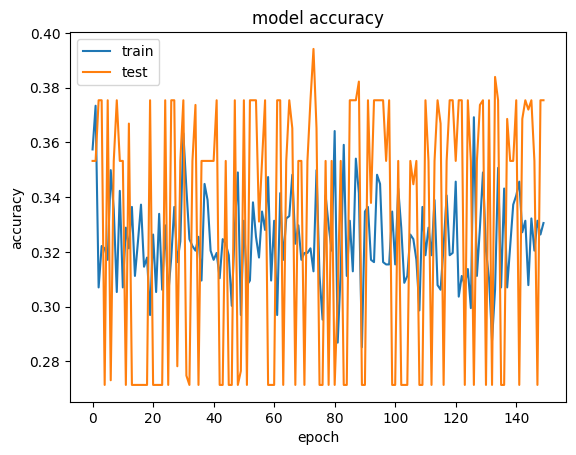

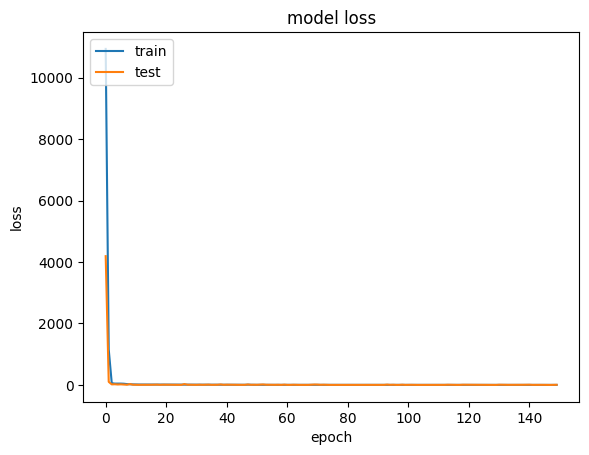

In [237]:
# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [238]:

# make predictions

# input - 2 features


input_list = [np.expand_dims(np.atleast_2d(trainX[i:examples+i,:]), axis=0) for i in xrange(nb_samples_x)]
input_mat = np.concatenate(input_list[0:1778], axis=0)
#print(input_mat)
trainPredict = model.predict(input_mat)
print(trainPredict)
print(trainPredict.mean(axis=1).shape)
trainPredict=trainPredict.mean(axis=1)

input_list = [np.expand_dims(np.atleast_2d(testX[i:examples+i,:]), axis=0) for i in xrange(nb_samples_y)]
input_mat = np.concatenate(input_list[0:746 ], axis=0)
testPredict = model.predict(input_mat)
testPredict=testPredict.mean(axis=1)



'''
print(trainPredict[0:])
print(trainPredict.shape)

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)



print(trainPredict)


scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer
obj = scaler.fit(trainPredict)
trainPredict= obj.inverse_transform(trainPredict)
print(trainPredict)

obj = scaler.fit(testPredict)
testPredict= obj.inverse_transform(testPredict)
'''
#trainY= scaler.inverse_transform(trainY)
#testY= scaler.inverse_transform(testY)



56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
[[103.88616  103.836365 103.71035 ]
 [103.88094  103.83145  103.705246]
 [103.18833  103.14074  103.01472 ]
 ...
 [104.26873  104.17907  104.077576]
 [104.29519  104.205635 104.10405 ]
 [104.34595  104.25666  104.1549  ]]
(1775,)
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


'\nprint(trainPredict[0:])\nprint(trainPredict.shape)\n\ntrainPredict = model.predict(trainX)\ntestPredict = model.predict(testX)\n\n\n\nprint(trainPredict)\n\n\nscaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer\nobj = scaler.fit(trainPredict)\ntrainPredict= obj.inverse_transform(trainPredict)\nprint(trainPredict)\n\nobj = scaler.fit(testPredict)\ntestPredict= obj.inverse_transform(testPredict)\n'

Training dataset RMSE:3.3597371530779316
Coefficient of Determination 0.6690747721832391


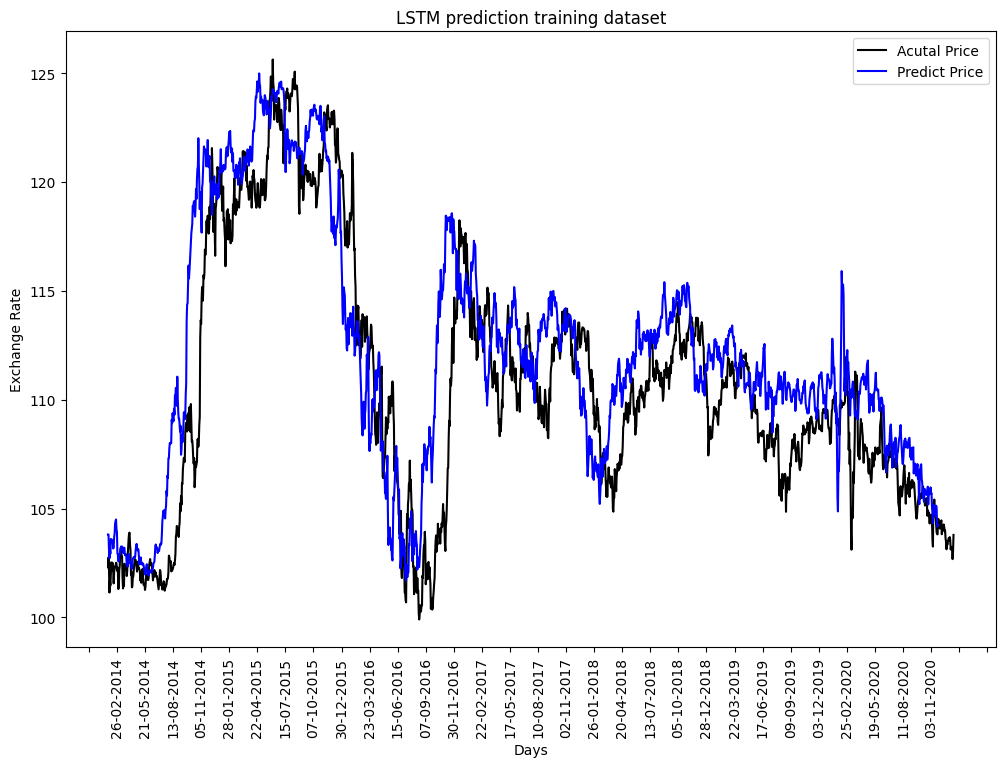

In [242]:

'''
Predict_list = []
for sublist in trainPredict:
     #print(sublist)
     Predict_list.extend(sublist[0:1])

trainY=np.array(trainY)
Predict_list=np.array(Predict_list)
'''
#print(trainY)
#print(Predict_list)
plt.figure(figsize=(12, 8))
plt.plot(trainY, color = 'black', label = 'Acutal Price')
#plt.plot(trainPredict, color = 'blue', label = 'Predict Price')
plt.plot(data[: trainPredict.shape[0] ].index,trainPredict, color = 'blue', label = 'Predict Price')
plt.title('LSTM prediction training dataset')
plt.ylabel('Exchange Rate')
plt.xlabel('Days')
plt.legend(loc = 'upper right')
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60))
plt.xticks(rotation=90)

#print(trainY[0:1778].shape)
#print(trainPredict.shape)

MSE = mean_squared_error(trainY[0:1775], trainPredict)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

from sklearn.metrics import r2_score

R_square = r2_score(trainY[0:1775], trainPredict)
print('Coefficient of Determination', R_square)




Training dataset RMSE:10.454253510981477
Coefficient of Determination 0.48825725012212073


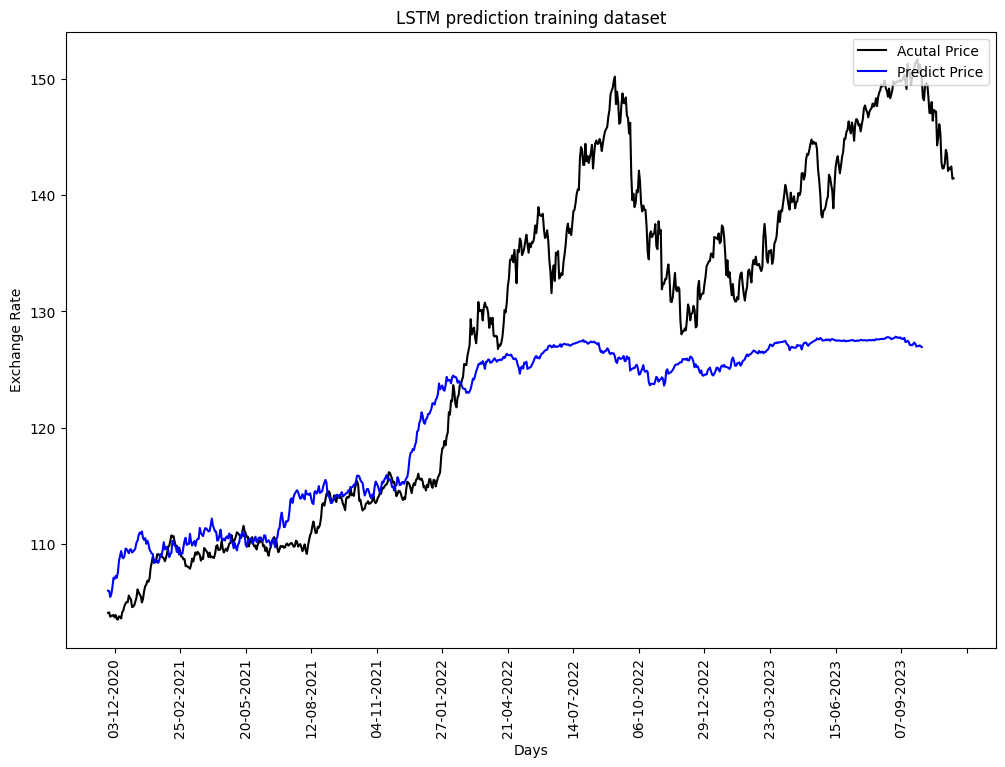

In [246]:
'''

Predict_list = []
for sublist in testPredict:
    Predict_list.extend(sublist)

trainY=np.array(trainY)
Predict_list=np.array(Predict_list)

#print(trainY)
#print(Predict_list)
'''
plt.figure(figsize=(12, 8))
plt.plot(testY, color = 'black', label = 'Acutal Price')
#plt.plot(testPredict, color = 'blue', label = 'Predict Price')
plt.plot(data[trainPredict.size : trainPredict.size+testPredict.shape[0] ].index,testPredict, color = 'blue', label = 'Predict Price')
plt.title('LSTM prediction training dataset')
plt.ylabel('Exchange Rate')
plt.xlabel('Days')
plt.legend(loc = 'upper right')
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60))
plt.xticks(rotation=90)

MSE = mean_squared_error(testY[0:746], testPredict)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

from sklearn.metrics import r2_score

R_square = r2_score(testY[0:746], testPredict)
print('Coefficient of Determination', R_square)


